In [1]:
import huggingface_hub
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

import os
from dotenv import load_dotenv
from collections import defaultdict

In [2]:
load_dotenv(".env")

True

In [3]:
def load(data_path, split):
        res = list()
        with open(os.path.join(data_path, f'{split}_text.txt'), encoding="utf-8") as f:
            text = f.readlines()
        
        with open(os.path.join(data_path, f'{split}_labels.txt'), encoding="utf-8") as f:
            labels = f.readlines()

        for i, (t, l) in enumerate(zip(text, labels)):
            res.append({
                "text": t,
                "label": int(l.strip())
            })
        return res

In [4]:
huggingface_hub.login(os.environ["HFTOKEN"])

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\vilyi\.cache\huggingface\token
Login successful


In [5]:
# dataset = load_dataset()
# "label", "text"
DATAPATH = r"..\tweeteval-emotion_recognition\data"
train_data = load(DATAPATH,"train")
val_data = load(DATAPATH,"val")
test_data = load(DATAPATH,"test")

with open(os.path.join(DATAPATH, "mapping.txt")) as f:
    id2label = {int(line.split()[0]): line.split()[1] for line in f}

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
# 66_956_548 parameters
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id={label: id for id, label in id2label.items()}
)

# Parameters
model.num_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


66956548

In [8]:
import numpy as np

accuracy = evaluate.load("accuracy")

def tokenize(data):
    texts, labels = zip(*[(d["text"], d["label"]) for d in data])
    texts = tokenizer(list(texts), truncation=True, padding=True)
    return [{"input_ids": text, "label": label} for text, label in zip(texts["input_ids"], labels)]

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [9]:
tokenized_train_data = tokenize(train_data)
tokenized_val_data = tokenize(val_data)
tokenized_test_data = tokenize(test_data)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

{'eval_loss': 0.6910654902458191, 'eval_accuracy': 0.7647058823529411, 'eval_runtime': 1.8031, 'eval_samples_per_second': 207.425, 'eval_steps_per_second': 13.311, 'epoch': 1.0}


  0%|          | 0/24 [00:00<?, ?it/s]

{'eval_loss': 0.6206287145614624, 'eval_accuracy': 0.767379679144385, 'eval_runtime': 1.2284, 'eval_samples_per_second': 304.461, 'eval_steps_per_second': 19.538, 'epoch': 2.0}
{'train_runtime': 93.2123, 'train_samples_per_second': 69.884, 'train_steps_per_second': 4.377, 'train_loss': 0.8014448577282476, 'epoch': 2.0}


TrainOutput(global_step=408, training_loss=0.8014448577282476, metrics={'train_runtime': 93.2123, 'train_samples_per_second': 69.884, 'train_steps_per_second': 4.377, 'total_flos': 104494631894688.0, 'train_loss': 0.8014448577282476, 'epoch': 2.0})

In [16]:
import torch

model = trainer.model

print(model.state_dict().keys())
torch.save(model.state_dict(), "distilbert-base-uncased-emotion-recognition.pt")

odict_keys(['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.output_layer_norm.

In [20]:
# Test the model
from transformers import pipeline

label2id = {label: id for id, label in id2label.items()}
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
model.load_state_dict(torch.load("distilbert-base-uncased-emotion-recognition.pt"))
model.eval()

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
test_texts = [d["text"] for d in test_data]

predictions = classifier(test_texts)

In [24]:
predictions = [p["label"] for p in predictions]
labels = [d["label"] for d in test_data]
accuracy.compute(predictions=[label2id[p] for p in predictions], references=labels)

{'accuracy': 0.7733990147783252}

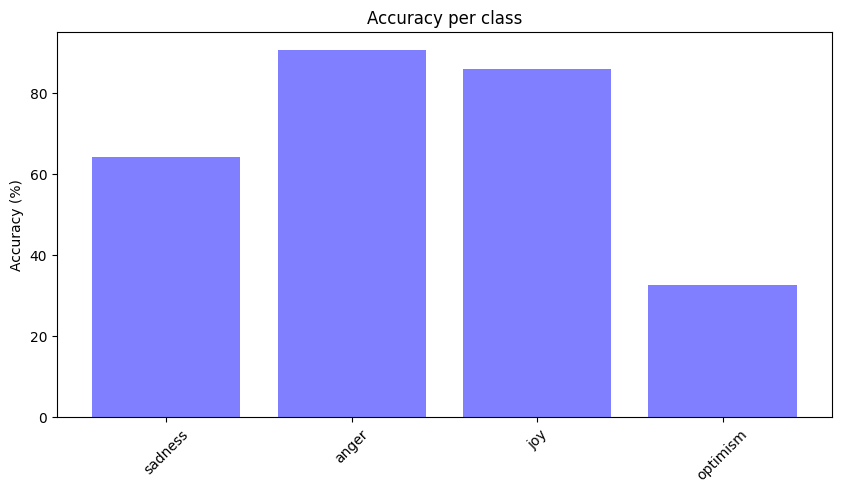

In [42]:

# accuracy per class
class_counts = defaultdict(int)
class_corrects = defaultdict(int)

for cls, pred in zip(labels, [label2id[p] for p in predictions]):
    class_counts[cls] += 1
    if cls == pred:
        class_corrects[cls] += 1

class_accuracies = {id2label[cls]: (class_corrects[cls] / class_counts[cls])*100 for cls in class_counts}

import matplotlib.pyplot as plt
import seaborn as sns

def plot_acc_per_class(acc_per_class: dict):
    plt.figure(figsize=(10, 5))
    plt.bar(acc_per_class.keys(), acc_per_class.values(), color="blue", alpha=0.5)
    plt.xticks(rotation=45)
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per class")
    plt.show()

plot_acc_per_class(class_accuracies)

In [ ]:

# Confusion matrix
confusion_matrix = np.zeros((len(id2label), len(id2label)))

for cls, pred in zip(labels, [label2id[p] for p in predictions]):
    confusion_matrix[cls, pred] += 1

confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, xticklabels=id2label.values(), yticklabels=id2label.values(), cmap="Blues")
plt.show()